### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 6
### Due: Saturday, Mar 22nd at 11.59pm CT
---

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [3]:
import numpy as np
from scipy import stats
import scipy.special as sp

from matplotlib import pyplot as plt
import corner.corner as corner
import emcee
import acor
import dynesty
import ultranest
from ultranest.plot import cornerplot
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity, KNeighborsRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler

ModuleNotFoundError: No module named 'corner'

In [1]:
# Kludge to fix the bug with draw_ellipse in astroML
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,
                          **kwargs))

'''
1)Read in hw6_data_1.npy. The dataset should consist of  samples with  features.
Note that the last column are the labels, not another feature. Make a 2-D scatter plot 
of the data colored by their labels.
'''
data = np.load("hw_data/hw6_data_1.npy")
feat1 = data[:, 0] #feature 1 and 2
feat2 = data[:, 1]  
labels = data[:, 2]  

plt.scatter(feat1,feat2,c=labels)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()
plt.show()



NameError: name 'np' is not defined

Optimal bandwidth: 0.503448275862069
[2.65579358e-23 6.42736135e-22 1.11958288e-20 ... 2.35663837e-81
 3.25844956e-83 3.24257214e-85]


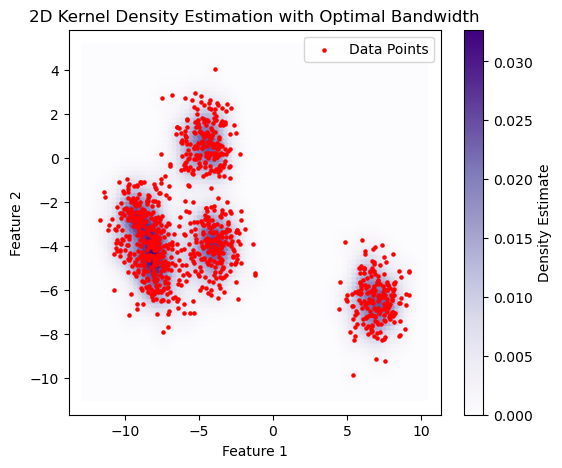

In [83]:
'''
2) Start with kernel density estimation on the data set. First, perform a grid search 
-fold cross-validation to find the best bandwidth, testing  bandwidths between and . What 
is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density
estimate of the distribution.
'''

np.random.seed(1)

# bandwidths to search over
bandwidths = np.linspace(0.1, 1, 30)

# Number of folds for cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
X = np.vstack([feat1, feat2]).T  # Stack features into (N,2) shape

#found this cheeky library
grid = GridSearchCV(KernelDensity(kernel='gaussian'), 
                     {'bandwidth': bandwidths}, 
                     cv=kf)
grid.fit(X)
best_bw = grid.best_params_['bandwidth']
print(f"Optimal bandwidth: {best_bw}")

# Fit KDE with optimal bandwidth
kde = KernelDensity(kernel='gaussian', bandwidth=best_bw)
kde.fit(X)

# Generate grid for density estimation
u = np.linspace(feat1.min() - 1, feat1.max() + 1, 80)
v = np.linspace(feat2.min() - 1, feat2.max() + 1, 80)
Xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T

# Compute density estimates
dens = np.exp(kde.score_samples(Xgrid))  # Convert log-density to normal density
print(dens)

# Plot results
plt.figure(figsize=(6, 5))
plt.scatter(Xgrid[:, 0], Xgrid[:, 1], c=dens, cmap="Purples", edgecolor="None")
plt.colorbar(label="Density Estimate")
plt.scatter(feat1, feat2, color="red", s=5, label="Data Points")  # Overlay original data points
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("2D Kernel Density Estimation with Optimal Bandwidth")
plt.legend()
plt.show()
#best bandwidth, plot the two-dimensional kernel density estimate of the distribution. DE=0.05

#ADD THIS PART 

SRT: This is a novel solution! I've never had a student do it quite this way, but you basically got the optimal answer, and I really like your visualization. Well done!

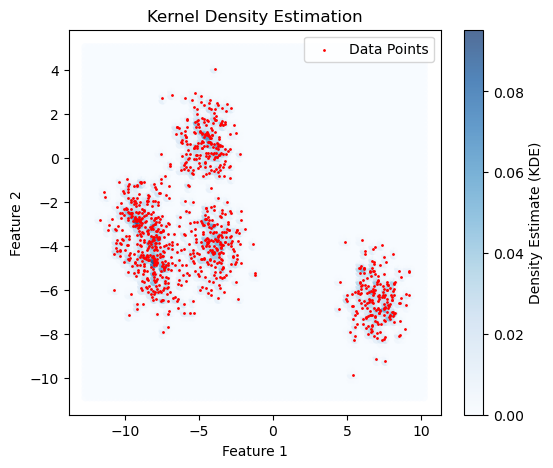

In [84]:
'''
3)Now try a nearest neighbors approach to estimating the density. Use 
the Bayesian nearest neighbors option. Plot the estimated distribution.
What value of  neighbors do you need to make the plot look similar to
your KDE distribution?
'''
np.random.seed(0)

# Assume feat1 and feat2 are already defined
X = np.vstack([feat1, feat2]).T  # Stack features into (N,2) shape

# Define grid for density estimation
u = np.linspace(feat1.min() - 1, feat1.max() + 1, 80)
v = np.linspace(feat2.min() - 1, feat2.max() + 1, 80)
Xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T

# KDE density estimation
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(X)
dens_kde = np.exp(kde.score_samples(Xgrid))  # Convert log-density to normal density

# Bayesian nearest neighbors density estimation
k = 5  # Initial number of neighbors (to be optimized)
nbrs = KNeighborsRegressor(n_neighbors=k, weights='distance')  
nbrs.fit(X, np.ones(len(X)))  # Fit to uniform density
dens_nbrs = nbrs.predict(Xgrid) / len(X)  # Normalize by number of points

# Plot results
'''plt.figure(figsize=(6, 5))
plt.scatter(Xgrid[:, 0], Xgrid[:, 1], c=dens_nbrs, cmap="Purples", edgecolor="None", alpha=0.7)
plt.colorbar(label="Density Estimate (Bayesian NN)")
plt.scatter(feat1, feat2, color="red", s=5, label="Data Points")  # Overlay original data points
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title(f"Bayesian Nearest Neighbors Density Estimation (k={k})")
plt.legend()
plt.show()
'''
# KDE Plot for Comparison
plt.figure(figsize=(6, 5))
plt.scatter(Xgrid[:, 0], Xgrid[:, 1], c=dens_kde, cmap="Blues", edgecolor="None", alpha=0.7)
plt.colorbar(label="Density Estimate (KDE)")
plt.scatter(feat1, feat2, color="red", s=1, label="Data Points")  # Overlay original data points
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Kernel Density Estimation")
plt.legend()
plt.show()

SRT: The KDE plot was included for comparison, but you did not uncomment the KNN plot. Also, there is no evidence that I could see of experimentation with the number of nearest neighbors, or a statement of what you found to be optimal to match the KDE reconstruction. -4 points.

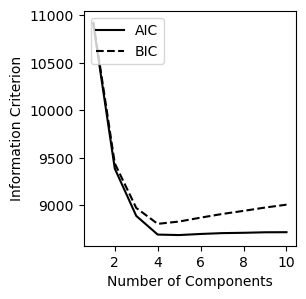

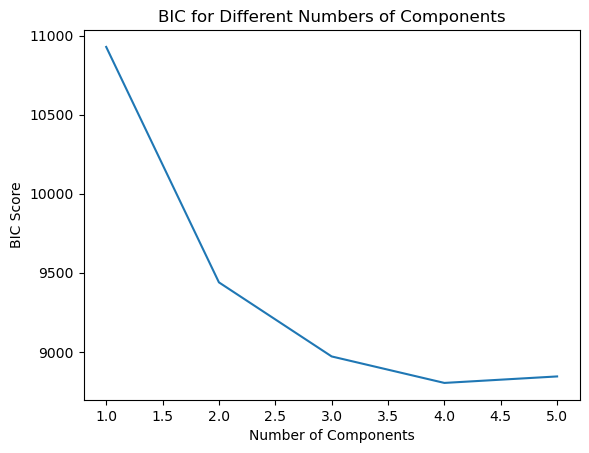

In [85]:
'''
4)Now fit a Gaussian mixture model. Compute the AIC and BIC for the number
of GMM components between  and . Plot these AIC and BIC values as a function 
of number of components. What is the optimal number according to the BIC? Fit 
the data set with this optimal number of GMM components, and create a new plot 
that shows the data set, the GMM component mean locations, and the -sigma GMM 
component ellipses.
'''
# Generate synthetic data (X)
X = np.vstack([feat1, feat2]).T 

# : Compute BIC and AIC for different components
N = np.arange(1, 11)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(n_components=N[i]).fit(X)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

# Plot AIC and BIC for different components
fig = plt.figure(figsize=(10, 3.4))
fig.subplots_adjust(left=0.12, right=0.97, bottom=0.21, top=0.9, wspace=0.5)

ax = fig.add_subplot(132)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.set_xlabel('Number of Components')
ax.set_ylabel('Information Criterion')
ax.legend(loc=2)
plt.show()

# Step 4: BIC for a smaller range of components (1 to 5)
BIC = []
for ii in range(1, 6):
    gmm = GaussianMixture(n_components=ii)
    gmm.fit(X)
    BIC.append(gmm.bic(X))

# Step 5: Plot BIC for 1 to 5 components
plt.plot(np.arange(1, 6), BIC)
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.title('BIC for Different Numbers of Components')
plt.show()



SRT: Good!

"\nThis method was one I was working on before i READ THE END OF THE PROMPT... reading is essential\nax = plt.gca()\nfor i in range(optimal_components):\n    covar = gmm.covariances_[i]\n    v, w = np.linalg.eigh(covar)  # Eigenvalues and eigenvectors of covariance matrix\n    v = 2.0 * np.sqrt(2) * np.sqrt(v)  # Scale for -sigma ellipse\n    angle = np.arctan(w[0, 1] / w[0, 0]) * 180 / np.pi  # Angle of rotation\n    \n    # Create the ellipse\n    ellipse = Ellipse(xy=means[i], width=v[0], height=v[1], angle=angle, color='black', alpha=0.5)\n    ax.add_patch(ellipse)"

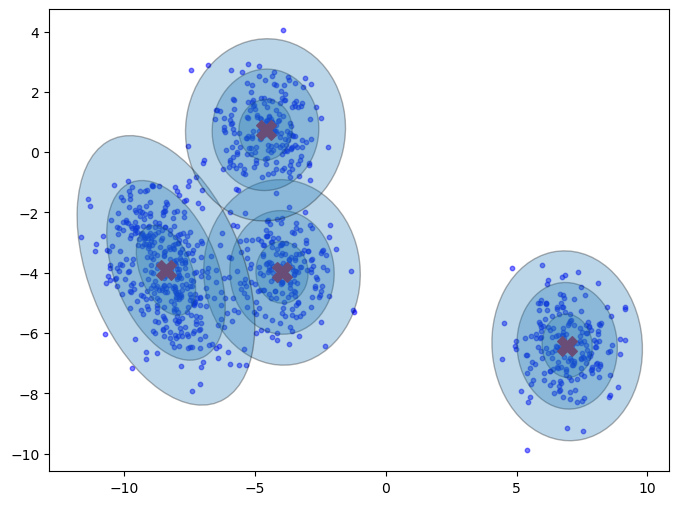

In [86]:
optimal_components = 4  # Optimal number of components
gmm = GaussianMixture(n_components=optimal_components)
gmm.fit(X)
#and create a new plot that shows the data set, the GMM component mean locations, and the -sigma GMM 
#component ellipses
# Plot the data points
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], s=10, color='blue', alpha=0.5, label='Data')

# Get the component means
means = gmm.means_
covariances = gmm.covariances_

# Plot the component means as red points
plt.scatter(means[:, 0], means[:, 1], c='red', s=200, marker='X', label='Component Means')
ax = plt.gca()
for i in range(optimal_components):
    draw_ellipse(means[i], covariances[i], scales=[1, 2, 3], ax=ax, edgecolor='black', alpha=0.3)
'''
This method was one I was working on before i READ THE END OF THE PROMPT... reading is essential
ax = plt.gca()
for i in range(optimal_components):
    covar = gmm.covariances_[i]
    v, w = np.linalg.eigh(covar)  # Eigenvalues and eigenvectors of covariance matrix
    v = 2.0 * np.sqrt(2) * np.sqrt(v)  # Scale for -sigma ellipse
    angle = np.arctan(w[0, 1] / w[0, 0]) * 180 / np.pi  # Angle of rotation
    
    # Create the ellipse
    ellipse = Ellipse(xy=means[i], width=v[0], height=v[1], angle=angle, color='black', alpha=0.5)
    ax.add_patch(ellipse)'''

SRT: Good work, Ayanah!

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

In [99]:
from sklearn.cluster import KMeans
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
num_clusters = 4 
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X_scaled)

KMeans(n_clusters=4)

SRT: But the question said to use 5... -1 point

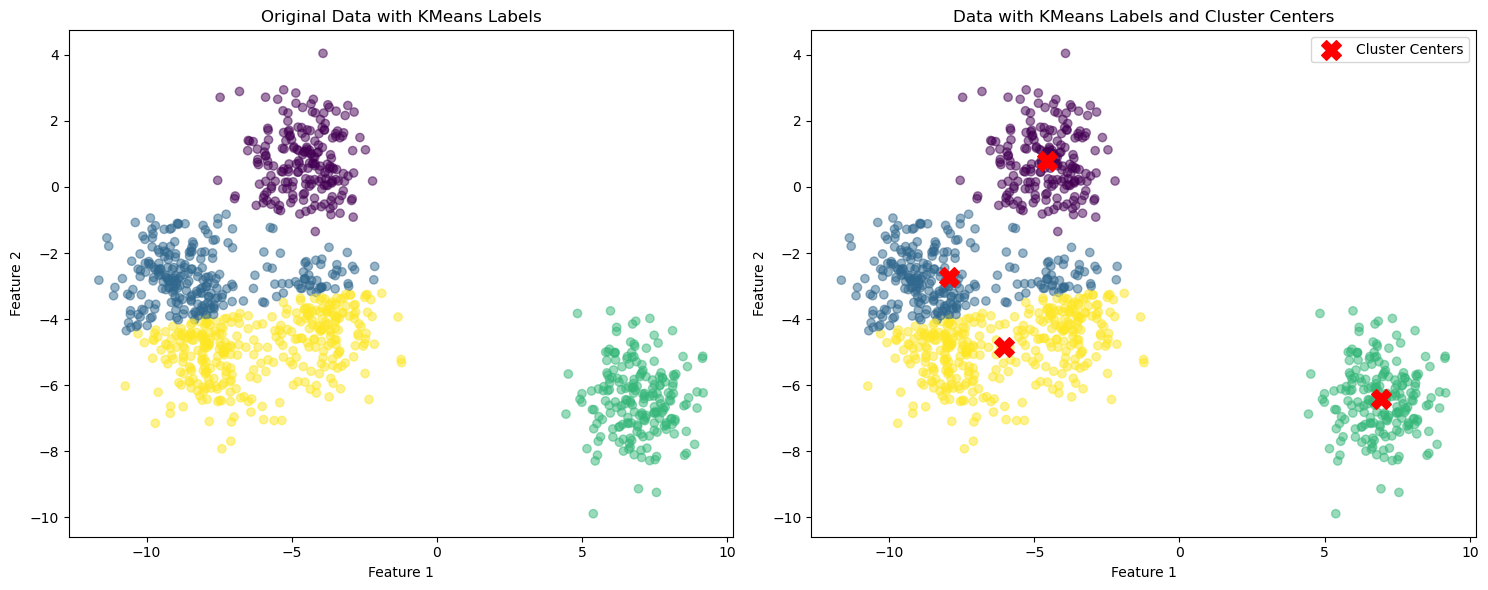

In [103]:
cluster_centers_scaled = kmeans.cluster_centers_
cluster_centers = scaler.inverse_transform(cluster_centers_scaled)

labels = kmeans.predict(X_scaled)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.5)
axes[0].set_title('Original Data with KMeans Labels')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

axes[1].scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.5)
axes[1].scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=200, marker='X', label='Cluster Centers')
axes[1].set_title('Data with KMeans Labels and Cluster Centers')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].legend()

# Show the plot
plt.tight_layout()
plt.show()

SRT: Great work, Ayanah. Just a few deductions and areas for improvement. 

45/50